In [1]:
# Get the data for expeirment
from Utils import data_utils, visualization_utils
from sklearn.preprocessing import StandardScaler
from torch_geometric.loader import DataLoader
import torch
import ab_wind_dataset
import experiment
import matplotlib.pyplot as plt
import os
os.environ["KERAS_BACKEND"] = "torch"
import keras

device = torch.device("cuda:0")
print(f"Keras version is {keras.__version__}")
print(f"Torch version is {torch.__version__}")
print(f"Num GPUs Available: {torch.cuda.device_count()}")
plt.rcParams.update({'font.size': 20})

Keras version is 3.1.1
Torch version is 2.0.1
Num GPUs Available: 1
Keras version is 3.1.1
Torch version is 2.0.1
Num GPUs Available: 1


In [2]:
ab_wind_dataset_train = ab_wind_dataset.AbWindDatasetTrain(experiment.dataset_file_location, experiment.number_of_neighbours)
ab_wind_dataset_test = ab_wind_dataset.AbWindDatasetTest(experiment.dataset_file_location, experiment.number_of_neighbours)

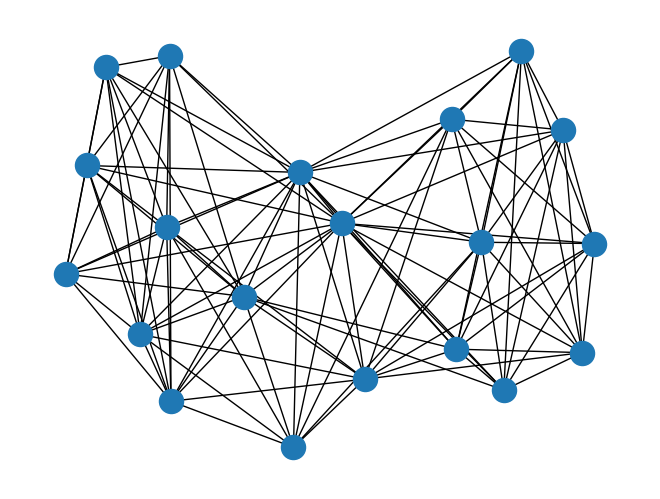

In [3]:
visualization_utils.get_graph_embedding_visualization(ab_wind_dataset_train.get(0))

In [4]:
dummy_model = experiment.GNNModel(num_node_features=5)

trained_model = experiment.run_model(dummy_model, ab_wind_dataset_train, 300, batch_size=32)

Epoch 1, Average Loss: 37.14715633392334, Time: 7.071521759033203
Epoch 2, Average Loss: 26.193123472522117, Time: 4.9292151927948
Epoch 3, Average Loss: 25.61380648584423, Time: 4.978888988494873
Epoch 4, Average Loss: 24.834256483980283, Time: 4.8275697231292725
Epoch 5, Average Loss: 24.05888666963863, Time: 4.961632490158081
Epoch 6, Average Loss: 23.918799123935358, Time: 5.071564435958862
Epoch 7, Average Loss: 24.007298825886433, Time: 4.897944211959839
Epoch 8, Average Loss: 23.839559512795088, Time: 4.841742515563965
Epoch 9, Average Loss: 23.796323619774, Time: 4.845740079879761
Epoch 10, Average Loss: 23.627625827446668, Time: 5.007235288619995
Epoch 11, Average Loss: 23.368773464956682, Time: 5.110548973083496
Epoch 12, Average Loss: 23.437672757816888, Time: 4.977198600769043
Epoch 13, Average Loss: 23.1940340213433, Time: 5.10484504699707
Epoch 14, Average Loss: 23.14109506664162, Time: 5.183672904968262
Epoch 15, Average Loss: 22.91610653700229, Time: 5.232621908187866
E

In [7]:
test_loader = DataLoader(ab_wind_dataset_test, batch_size=32, shuffle=True)
trained_model.eval()
mse_loss = torch.nn.MSELoss()
loss = 0  

actual = []
pred = []

for data in test_loader:
    data = data.to(device)
    target_nodes = data.target_node_index
    prediction = trained_model(data, target_nodes)
    target = data.y[target_nodes]
    loss += mse_loss(prediction, target)
    actual.extend(target.detach().cpu().numpy().flatten())
    pred.extend(prediction.detach().cpu().numpy().flatten())

average_loss = loss / len(test_loader)
print(f'Test Loss: {average_loss}')

Test Loss: 21.781925201416016


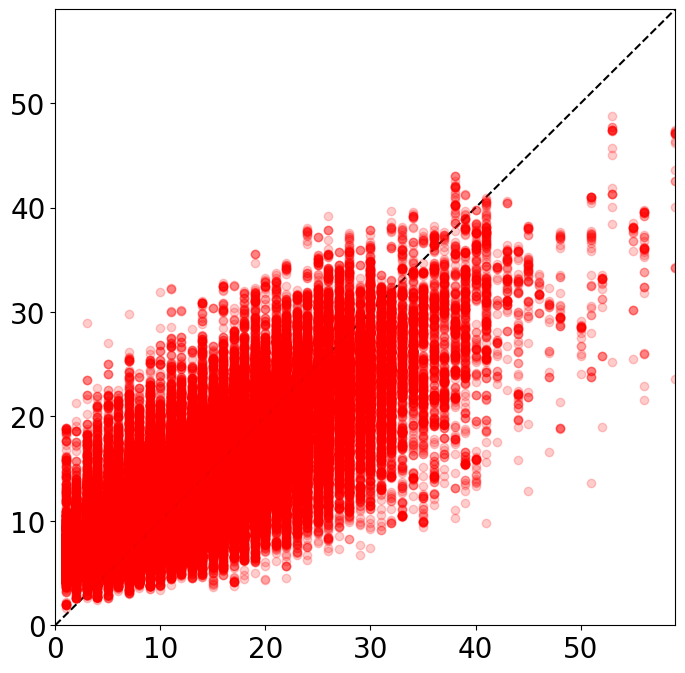

In [8]:
visualization_utils.get_error_plot(actual, pred)